**Imports**

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import pandas as pd
import  numpy as np
import altair
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

**Dataset analysis**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
epar_data_path = Path('/content/drive/MyDrive/sentences_with_sentiment.xlsx')

In [ ]:
epar_dataset = pd.read_excel(epar_data_path)

In [ ]:
epar_dataset.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


In [ ]:
for category in "Positive Negative 	Neutral".split():
  print(category)
  print(sum(epar_dataset[category]))
  print("*"*30)

Positive
160
******************************
Negative
36
******************************
Neutral
70
******************************


In [ ]:
sent_lens = epar_dataset.Sentence.str.len()

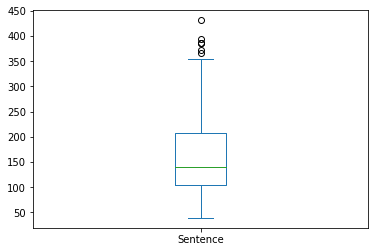

In [ ]:
sent_lens.plot.box()

In [ ]:
print(f"Max char length: {max(sent_lens)}", f"Min char length: {min(sent_lens)}" , f"Mean char length: {(sent_lens.mean()):.0f}")

Max char length: 431 Min char length: 39 Mean char length: 161


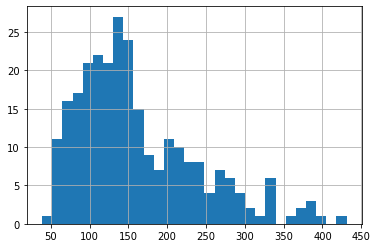

In [ ]:
hist = sent_lens.hist(bins=30)

**Checking some word representativness per category**

**Unigrams**


In [ ]:
sentences_pos = epar_dataset[epar_dataset["Positive"] == 1].Sentence
sentences_neg = epar_dataset[epar_dataset["Negative"] == 1].Sentence
sentences_neutral = epar_dataset[epar_dataset["Neutral"] == 1].Sentence

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
count_model = CountVectorizer(ngram_range=(1,1), stop_words='english') 
X_pos = count_model.fit_transform(sentences_pos)

In [ ]:
count_values = X_pos.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,47,safety
1,45,data
2,33,study
3,30,efficacy
4,28,clinical
5,27,patients
6,26,treatment
7,26,considered
8,23,profile
9,21,product


In [ ]:
X_neg = count_model.fit_transform(sentences_neg)

In [ ]:
count_values = X_neg.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,17,safety
1,14,data
2,12,patients
3,9,study
4,7,treatment
5,7,limited
6,6,term
7,6,studies
8,6,period
9,6,efficacy


In [ ]:
X_neutral = count_model.fit_transform(sentences_neutral)

In [ ]:
count_values = X_neutral.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,21,studies
1,17,safety
2,15,study
3,12,p10
4,12,ct
5,11,efficacy
6,11,dose
7,11,data
8,10,patients
9,10,insulin


In Positives and Negatives top freq words are similar, some of them are on  the same top positions. Besides there is not much to tell more without more context.

**Bigrams**

In [ ]:
count_model = CountVectorizer(ngram_range=(2,2), stop_words='english') 
X_pos = count_model.fit_transform(sentences_pos)

In [ ]:
count_values = X_pos.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,20,safety profile
1,15,ct p10
2,11,clinical data
3,9,p10 mabthera
4,8,sof vel
5,8,film coated
6,8,coated tablets
7,7,reference product
8,7,onset sma
9,7,efficacy data


In [ ]:
X_neg = count_model.fit_transform(sentences_neg)

In [ ]:
count_values = X_neg.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,5,long term
1,4,necessary address
2,4,following measures
3,4,considers following
4,4,chmp considers
5,3,updated data
6,3,study period
7,3,safety proflie
8,3,safety data
9,3,reach firm


In [ ]:
X_neutral = count_model.fit_transform(sentences_neutral)

In [ ]:
count_values = X_neutral.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,12,ct p10
1,6,insulin glargine
2,5,long term
3,4,term safety
4,4,safety profile
5,4,safety data
6,4,reference products
7,4,pivotal studies
8,4,et al
9,3,symptomatic infants


In all categories exist bigrams with p10 symbol, more symbols exist in Positives. Exist many bigrams with "word data", Negatives consist of bigrams that measure time. like "long term", "study period".

**Trigrams**

In [ ]:
count_model = CountVectorizer(ngram_range=(3,3), stop_words={'english'}) 
X_pos = count_model.fit_transform(sentences_pos)

In [ ]:
count_values = X_pos.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,15,safety profile of
1,14,the safety profile
2,10,based on the
3,9,p10 and mabthera
4,9,ct p10 and
5,8,film coated tablets
6,6,the reference product
7,6,sb5 and humira
8,6,of ct p10
9,6,in patients with


In [ ]:
X_neg = count_model.fit_transform(sentences_neg)

In [ ]:
count_values = X_neg.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,5,in order to
1,4,the following measures
2,4,the chmp considers
3,4,of the combination
4,4,necessary to address
5,4,considers the following
6,4,chmp considers the
7,3,very limited to
8,3,updated data are
9,3,up period should


In [ ]:
X_neutral = count_model.fit_transform(sentences_neutral)

In [ ]:
count_values = X_neutral.toarray().sum(axis=0)
x = sorted([(count_values[i],k) for k,i in count_model.vocabulary_.items()], reverse=True)[:20]
df = pd.DataFrame(x, columns =['Freq', 'Word'])

In [ ]:
df

,Freq,Word
0,4,term safety data
1,4,safety profile of
2,4,long term safety
3,4,in order to
4,3,will provide additional
5,3,were infections infusion
6,3,were generally lower
7,3,to that of
8,3,there was no
9,3,the rmp will


The top 20 3-grams are quite different between categories, but it is hard to interpret it with deeper context. Probabily they are somehow representational but 

**Check some sentences**

In [ ]:
for e in epar_dataset.sample(n=20).Sentence:
  print(e)

More detailed data on injection site reactions, hypersensitivity and anaphylactic reactions were requested in order to allow a thorough assessment of this issue both in subjects with and without ADAs.
The effect was consistent across studies and across investigated subgroups.
Therefore, the available safety data are considered supportive of biosimilarity between CT-P10 and MabThera.
There is a lack of long-term data beyond 30 weeks with the FRC. 
A summary of the literature with regard to clinical data of Pemetrexed Hospira UK Limited and justifications that the different salt of the active substance does not differ significantly in properties with regards to safety and efficacy of the reference product was provided and was accepted by the CHMP. 
No additional clinical studies were provided within current application.
Biosimilarity of CT-P10 and MabThera is considered demonstrated based on the efficacy data.
Data from the ongoing studies in infantile-onset SMA support that treatment wi

Ok, in the sentences occur a lot of code words, special names, numbers, abbreviations. Probably it is not a good idea to remove them at first or treat as a noise. It could be a good idea to normalize such text that is unroll names like RMS, ANC etc. I won't also do any lowercase. Because I want to start with base transformer model, I want to keep as much context for the start as possible.

**Training DL**

In [ ]:
from torch.utils.data import DataLoader
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np
from datasets import load_metric

In [ ]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
epar_dataset['sentiment'] = None
epar_dataset.loc[sentences_pos.index, 'sentiment'] = "Positive"
epar_dataset.loc[sentences_neg.index, 'sentiment'] = "Negative"
epar_dataset.loc[sentences_neutral.index, 'sentiment'] = "Neutral"

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(epar_dataset['sentiment'].unique())
epar_dataset['target'] = le.transform(epar_dataset['sentiment'])


In [ ]:
num_folds = 4
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
Fold = StratifiedGroupKFold(n_splits=num_folds, shuffle=True, random_state=666)
for n, (train_index, val_index) in enumerate(Fold.split(epar_dataset['Sentence'], epar_dataset['target'])):
    epar_dataset.loc[val_index, 'fold'] = int(n)
epar_dataset['fold'] = epar_dataset['fold'].astype(int)
train_df = epar_dataset[["Sentence", "target", "fold"]]

In [ ]:
lr = 2e-5
bs = 16
wd = 0.01
epochs = 4
max_len = 200

In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:

def get_trainer(d_train, d_valid):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(epar_dataset['sentiment'].unique()))
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none', logging_steps=10)
    return model ,Trainer(model, args, train_dataset=d_train, eval_dataset=d_valid,
                   tokenizer=tokenizer, compute_metrics=compute_metrics)

In [ ]:
def tokenize(row): 
  return tokenizer(row["input"], max_length=max_len, padding="max_length")

In [ ]:
metrics_history = {}
def train(fold):
  train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
  valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
  valid_labels = valid_folds['target'].values

  train_dataset = Dataset.from_pandas(train_folds).rename_column('target', 'label').rename_column('Sentence', 'input')
  valid_dataset = Dataset.from_pandas(valid_folds).rename_column('target', 'label').rename_column('Sentence', 'input')

  tok_ds_train = train_dataset.map(tokenize, batched=True, remove_columns=('input','fold'))
  tok_ds_valid = valid_dataset.map(tokenize, batched=True, remove_columns=('input','fold'))

  model, trainer = get_trainer(tok_ds_train, tok_ds_valid)
  trainer.train()
  metrics_history[fold] = [e for e in trainer.state.log_history]
  return model


In [ ]:
last_model_saved = None
for fold in range(num_folds):
  last_model_saved = train(fold)



  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/41943bf7f983007123c758373c5246305cc536ec/config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /root/.cache/hu

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.104200,0.924302,0.602941,0.453589
2,0.896600,0.873585,0.602941,0.457789
3,0.863700,0.820790,0.647059,0.544450
4,0.708700,0.807933,0.647059,0.546188


***** Running Evaluation *****
  Num examples = 68
  Batch size = 32
***** Running Evaluation *****
  Num examples = 68
  Batch size = 32
***** Running Evaluation *****
  Num examples = 68
  Batch size = 32
***** Running Evaluation *****
  Num examples = 68
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/41943bf7f983007123c758373c5246305cc536ec/config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /root/.cache/hu

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.062500,0.937471,0.597015,0.446366
2,0.913000,0.891551,0.597015,0.446366
3,0.800400,0.865264,0.611940,0.478857
4,0.745400,0.859843,0.611940,0.478857


***** Running Evaluation *****
  Num examples = 67
  Batch size = 32
***** Running Evaluation *****
  Num examples = 67
  Batch size = 32
***** Running Evaluation *****
  Num examples = 67
  Batch size = 32
***** Running Evaluation *****
  Num examples = 67
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/41943bf7f983007123c758373c5246305cc536ec/config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /root/.cache/hu

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.072200,0.918157,0.606061,0.457404
2,0.932400,0.862649,0.621212,0.490380
3,0.863800,0.841508,0.621212,0.490380
4,0.781800,0.837510,0.621212,0.490380


***** Running Evaluation *****
  Num examples = 66
  Batch size = 32
***** Running Evaluation *****
  Num examples = 66
  Batch size = 32
***** Running Evaluation *****
  Num examples = 66
  Batch size = 32
***** Running Evaluation *****
  Num examples = 66
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/41943bf7f983007123c758373c5246305cc536ec/config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /root/.cache/hu

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.082900,0.914998,0.615385,0.483429
2,0.932800,0.842841,0.615385,0.483429
3,0.776700,0.809448,0.646154,0.541828
4,0.754100,0.802755,0.646154,0.542725


***** Running Evaluation *****
  Num examples = 65
  Batch size = 32
***** Running Evaluation *****
  Num examples = 65
  Batch size = 32
***** Running Evaluation *****
  Num examples = 65
  Batch size = 32
***** Running Evaluation *****
  Num examples = 65
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
metrics_history

{0: [{'loss': 1.1042,
   'learning_rate': 1.9629172873477995e-05,
   'epoch': 0.77,
   'step': 10},
  {'eval_loss': 0.9243020415306091,
   'eval_accuracy': 0.6029411764705882,
   'eval_f1': 0.45358877495952504,
   'eval_runtime': 2.7293,
   'eval_samples_per_second': 24.915,
   'eval_steps_per_second': 1.099,
   'epoch': 1.0,
   'step': 13},
  {'loss': 0.8966,
   'learning_rate': 1.5766803221148676e-05,
   'epoch': 1.54,
   'step': 20},
  {'eval_loss': 0.8735854029655457,
   'eval_accuracy': 0.6029411764705882,
   'eval_f1': 0.45778867102396514,
   'eval_runtime': 2.1379,
   'eval_samples_per_second': 31.807,
   'eval_steps_per_second': 1.403,
   'epoch': 2.0,
   'step': 26},
  {'loss': 0.8637,
   'learning_rate': 9.317575866353293e-06,
   'epoch': 2.31,
   'step': 30},
  {'eval_loss': 0.8207899928092957,
   'eval_accuracy': 0.6470588235294118,
   'eval_f1': 0.5444496360417077,
   'eval_runtime': 2.1516,
   'eval_samples_per_second': 31.605,
   'eval_steps_per_second': 1.394,
   'epoch

We can visualize how Transfomer works during classification by visualizing attention layer.

In [ ]:
import torch
from transformers import TextClassificationPipeline

In [ ]:
# Explainability git clone https://github.com/hila-chefer/Transformer-Explainability.git

In [ ]:
tokenized = tokenizer("The sample size was calculated to provide adequate power of bioequivalence analysis.", return_tensors="pt")
tokenized.to("cuda:0")

{'input_ids': tensor([[  101,  1103,  6876,  2060,  1108, 10056,  1106,  2194, 12373,  1540,
          1104, 25128,  1162, 18276, 25388,  3622,   119,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [ ]:
outputs = last_model_saved(**tokenized, output_attentions=True)

In [ ]:
outputs[0]

tensor([[-0.2711,  0.1844,  0.9655]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

**Not DL approach with simple feature engineering**

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
vectorizer.fit(train_df.Sentence)

TfidfVectorizer()

In [ ]:
metrics = {}
def train_classic(model, fold):
  train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
  valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

  x_train = vectorizer.transform(train_folds.Sentence).toarray()
  y_train = train_folds.target
  clf.fit(x_train ,y_train)


  x_valid = vectorizer.transform(valid_folds.Sentence).toarray()
  y_valid= valid_folds.target
  y_valid_pred=clf.predict(x_valid)
  report=classification_report(y_valid, y_valid_pred,output_dict=True)
  metrics[fold] = report
  return model


In [ ]:
for fold in range(num_folds):
  clf = SVC()
  train_classic(clf, fold)

In [ ]:
for idx, fold in metrics.items():
  print(idx)
  print("+"*30)
  for cat, met in fold.items():
    print(cat)
    print(met)
    print("*"*30)
  print("\n")

0
++++++++++++++++++++++++++++++
0
{'precision': 1.0, 'recall': 0.1111111111111111, 'f1-score': 0.19999999999999998, 'support': 9}
******************************
1
{'precision': 1.0, 'recall': 0.2222222222222222, 'f1-score': 0.3636363636363636, 'support': 18}
******************************
2
{'precision': 0.6507936507936508, 'recall': 1.0, 'f1-score': 0.7884615384615385, 'support': 41}
******************************
accuracy
0.6764705882352942
******************************
macro avg
{'precision': 0.8835978835978836, 'recall': 0.4444444444444444, 'f1-score': 0.45069930069930075, 'support': 68}
******************************
weighted avg
{'precision': 0.7894491129785247, 'recall': 0.6764705882352942, 'f1-score': 0.5981232003290827, 'support': 68}
******************************


1
++++++++++++++++++++++++++++++
0
{'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 9}
******************************
1
{'precision': 1.0, 'recall': 0.05555555555555555, 'f1-score': 0

At first look it seems, that some simple FeatuereEngineering with SVC model (best acc. ~0.71), gives better results on CV set than DL finetuning approach (best acc. ~0.62). However looking at the metrics for seperate classes it is visible that  For this approach it could be good to do maybe more 